In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [459]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict



In [ ]:

def upload_data() :
  url = "Data/"
  X = pd.read_csv(url  + "X_train.csv", index_col= "ROW_ID")
  y = pd.read_csv(url  + "y_train.csv", index_col = "ROW_ID")
  Test_data = pd.read_csv(url  + "X_test.csv", index_col = "ROW_ID")
  sample_submission = pd.read_csv(url + 'sample_submission.csv',index_col='ROW_ID')
  return X, y, Test_data, sample_submission


def upload_data_2() :
  url = "Data/"
  X_train = pd.read_csv(url  + "non_isolated_days.csv", index_col= "ROW_ID")
  # X_train = pd.read_csv(url  + "small_df.csv", index_col= "ROW_ID")
  y_train = X_train['target']
  X_train.drop(columns=['target'], inplace = True)
  X_val = pd.read_csv(url  + "isolated_days.csv", index_col= "ROW_ID")
  y_val = X_val['target']
  X_val.drop(columns=['target'], inplace = True)
  Test_data = pd.read_csv(url  + "X_test.csv", index_col = "ROW_ID")
  sample_submission = pd.read_csv(url + 'sample_submission.csv',index_col='ROW_ID')
  return X_train, y_train, X_val, y_val, Test_data, sample_submission

def split_data(X, y, test_size : int = 0.2, to_numpy : bool = False):
  if to_numpy :
    X_train, X_, y_train, y_ = train_test_split(X.to_numpy(), y.to_numpy(), test_size=test_size, random_state=42)
  else :
    X_train, X_, y_train, y_ = train_test_split(X, y, test_size=test_size, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
  return X_train, X_val, X_test, y_train, y_val, y_test

def save_pred(y_pred, name) :
  y_pred = (y_pred > 0).astype(int)
  temp = pd.DataFrame(y_pred, index = sample_submission.index, columns=['prediction'])  # target
  temp.to_csv("Submissions/"+name+".csv", index=True)




In [472]:
# Pre-processing method

def pre_process_1(df, standarize : bool = False):
  df = df.fillna(0)
  if standarize :
    df.iloc[:, 2:] = (df.iloc[:, 2:] - df.iloc[:, 2:].mean())/df.iloc[:, 2:].std()
  encoder = OneHotEncoder().fit(df[['ALLOCATION']])
  Z= encoder.transform(df[['ALLOCATION']]).toarray()
  df[[f'ALLOC_{i}' for i in range(Z.shape[1])]] = Z
  df = df.fillna(0)
  df.drop(columns=['TS', 'ALLOCATION'], inplace = True)
  return df

def pre_process_2(df, standarize : bool = False):
  df.drop(columns=['TS'], inplace = True)
  for i in [2, 5, 10, 15, 20] :
    df[ f'mean_RET_{i}'] =  df[RET_features[:i+1]].mean(1)
    df[ f'mean_SIGNED_VOLUME_{i}']=  df[SIGNED_VOLUME_features[:i+1]].mean(1)
    df[ f'sigma_RET_{i}'] =  df[RET_features[:i+1]].std(1)
    df[ f'sigma_SIGNED_VOLUME_{i}']=  df[SIGNED_VOLUME_features[:i+1]].std(1)
    df[f'var_SIGNED_VOLUME_{i}'] =  df[SIGNED_VOLUME_features[:i+1]].var(1)
    df[ f'allocations_AVERAGE_PERF_{i}'] = df.groupby('TS')[ f'mean_RET_{i}'].transform('mean')
  if standarize :
    df.iloc[:, 2:] = (df.iloc[:, 2:] - df.iloc[:, 2:].mean())/df.iloc[:, 2:].std()
  encoder = OneHotEncoder().fit(df[['ALLOCATION']])
  Z= encoder.transform(df[['ALLOCATION']]).toarray()
  df[[f'ALLOC_{i}' for i in range(Z.shape[1])]] = Z
  df = df.fillna(0)
  df.drop(columns=['TS', 'ALLOCATION'], inplace = True)
  return df

def pre_process_3(df) :
  df = df.fillna(0)
  for i in [3, 5, 10, 15, 20] :
    df[ f'mean_RET_{i}'] =  df[RET_features[:i+1]].mean(1)
    df[ f'sigma_RET_{i}'] =  df[RET_features[:i+1]].std(1)
    df[f'sharpe_RATIO_{i}'] = df[ f'mean_RET_{i}'] / df[ f'sigma_RET_{i}']
    df[ f'mean_SIGNED_VOLUME_{i}']=  df[SIGNED_VOLUME_features[:i+1]].mean(1)
    df[ f'allocations_AVERAGE_PERF_{i}'] = df.groupby('TS')[ f'mean_RET_{i}'].transform('mean')
  df['min_RET'] = df[RET_features].min(1)
  df['max_RET'] = df[RET_features].max(1)
  df['median_RET'] = df[RET_features].median(1)
  df['min_SIGNED_VOLUME'] = df[SIGNED_VOLUME_features].min(1)
  df['max_SIGNED_VOLUME'] = df[SIGNED_VOLUME_features].max(1)
  df['median_SIGNED_VOLUME'] = df[SIGNED_VOLUME_features].median(1)

  for i in range(1, 21) :
    df[f'RET*VOL_{i}'] = df[f'RET_{i}'] * df[f'SIGNED_VOLUME_{i}']
  df.drop(columns=['TS', 'ALLOCATION'], inplace = True)
  return df

In [473]:
RET_features = [f'RET_{i}' for i in range(1,21)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1,21)]
TURNOVER_features = ['AVG_DAILY_TURNOVER']
allocations_AVERAGE_PERF_features = [f'allocations_AVERAGE_PERF_{i}' for i in [3, 5, 10, 15, 20]]
new_features =  [f'mean_RET_{i}' for i in [3, 5, 10, 15, 20]] + [f'sigma_RET_{i}' for i in [3, 5, 10, 15, 20]]
new_features += ['min_RET', 'max_RET', 'median_RET', 'min_SIGNED_VOLUME', 'max_SIGNED_VOLUME', 'median_SIGNED_VOLUME']
new_features +=  [f'sharpe_RATIO_{i}' for i in [3, 5, 10, 15, 20]] + [f'mean_SIGNED_VOLUME_{i}' for i in [3, 5, 10, 15, 20]]
new_new_features = [f'RET*VOL_{i}' for i in range(1, 21)]

In [474]:
X_train, y_train, X_val, y_val, Test_data, sample_submission = upload_data_2()

X_train_alloc = X_train['ALLOCATION']
X_val_alloc = X_val['ALLOCATION']
Test_data_alloc = Test_data['ALLOCATION']

X_train = pre_process_3(X_train)
X_val = pre_process_3(X_val)
Test_data = pre_process_3(Test_data)

# 1- Ridge Regression


In [475]:

def ridge_cross_validation(X_train, y_train,  alphas : np.array = None, low : float = 0, high : float = 1, num_points : int = 1 , cv : int = 5,
                           plot : bool = True, X_val : np.array = None, y_val : np.array = None) :

  if alphas is None :
    alphas = np.linspace(low, high, num_points)

  kf = KFold(n_splits=cv, shuffle=True, random_state=10)

  acc_scores, std_acc_scores = [], []
  coefs, std_coefs = [], []


  for _, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha, fit_intercept=False, solver="svd")
    acc, temp_coefs = [], []
    CV = cross_validate(ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', return_estimator=True)

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
      y_pred = CV['estimator'][i].predict(X_train[test_index])
      acc.append(np.mean(np.sign(y_train[test_index]) == np.sign(y_pred)))
      temp_coefs.append(CV['estimator'][i].coef_)

    # Compute metrics
    acc = np.array(acc)
    acc_scores.append(np.mean(acc))
    std_acc_scores.append(np.std(acc))

    # Coefficients
    temp_coefs = np.array(temp_coefs)
    coefs.append(np.array(temp_coefs).mean(0))
    std_coefs.append(np.array(temp_coefs).std(0))


  acc_scores = np.array(acc_scores)
  std_acc_scores = np.array(std_acc_scores)
  coefs = np.array(coefs)
  std_coefs = np.array(std_coefs)

  if plot :
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_ylabel('Sign Accuracy (%)')
    if len(alphas) < 20 :
      ax.errorbar(np.arange(len(alphas)), acc_scores * 100, yerr=2 * std_acc_scores * 100,fmt='o',color='red',ecolor='gray',capsize=4,linestyle='-',label=r'Accuracy Mean $\pm 2\sigma$')
      ax.set_xticks(np.arange(len(alphas)))
      ax.set_xticklabels(alphas)
      ax.tick_params(axis='x', rotation = 45)
    else :
      ax.errorbar(alphas, acc_scores * 100, yerr = 2*std_acc_scores * 100, fmt='o', color='red', ecolor='gray',capsize=4,linestyle='-',label=r'Accuracy Mean $\pm 2\sigma$')

    if X_val is not None :
      val_acc_scores = []
      for alpha in alphas :
        model = Ridge(alpha=alpha, fit_intercept = False, solver = 'svd').fit(X_train, y_train)
        val_acc_scores.append(np.mean(np.sign(model.predict(X_val)) == np.sign(y_val)))
      val_acc_scores = np.array(val_acc_scores)
      if len(alphas) < 20 :
        ax.plot(np.arange(len(alphas)), val_acc_scores*100, label = 'Validation Accuracy')
      else :
        ax.plot(alphas, val_acc_scores*100, label = 'Validation Accuracy')

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    plt.title(r"Ridge Regression: Sign Accuracy vs $\alpha$")
    plt.show()

  return alphas, acc_scores, std_acc_scores, coefs, std_coefs


def cross_validate_ridge(X_train, y_train, alphas :  np.array = None, low : float = 0, high : float = 1, num_points : int = 1,
                         cv : int = 5,  plot : bool = True,  X_val : np.array = None, y_val : np.array = None,
                         save : bool = False, name : str = None) :


  if alphas is None :
    alphas = np.linspace(low, high, num_points)
  alphas, acc_scores, std_acc_scores, coefs, std_coefs = ridge_cross_validation(X_train, y_train, alphas,
                                                                                  low, high, num_points, cv,
                                                                                  plot, X_val = X_val, y_val = y_val)
  best_id = np.argmax(acc_scores-std_acc_scores)
  alpha = alphas[best_id]
  model = Ridge(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
  print(f'Optimal l2 penalization = {alpha}')

  # Cross Validation Score
  mean, std = acc_scores[best_id], std_acc_scores[best_id]
  print(f'Ridge - CV Classification Accuracy: {mean * 100}%, [{(mean - std)*100:.3f}% ; {(mean + std)*100:.3f}%] (+- {std * 100:.3f})')

  # Train Set Score
  print(f'Ridge - Train Classification Accuracy: {np.mean(np.sign(model.predict(X_train)) == np.sign(y_train.flatten()))*100}%')

  if X_val is not None :
    print(f'Ridge - Validation Set Classification : {np.mean(np.sign(model.predict(X_val)) == np.sign(y_val.flatten()))*100}%') # Valdiation Set Score

  if save :
    save_pred(model.predict(Test_data), name)


  return alpha



In [476]:
def regression_coefficients(X, y, features, alpha : float = 0.0, return_selected : bool = False, barplot_zvalue : bool = False, barplot_coef : bool = False, std_coefs : np.array = None, coefs : np.array = None):


  features = np.array(features)
  columns = ['feature', 'coef', 'std', 'Z_value']
  tab  = [features]

  if (coefs is not None )and (std_coefs is not None ):
    tab.append(std_coefs.flatten())
    tab.append(coefs)
  else :
    V, D2, _ = np.linalg.svd(X.T @ X)
    M = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1]))
    beta = M @ X.T @ y
    sigma2 = mean_squared_error(y, X @ beta) * X.shape[0] / (X.shape[0] - (D2 / (D2 + alpha)).sum()) # Estimation of the observation's variance based on degree of freedom
    cov = sigma2 * V @ np.diag(D2 / (D2+alpha)**2) @ V.T # Var(beta_hat)
    tab.append(beta)
    tab.append(np.diag(cov)**0.5)

  tab.append(tab[1]/tab[2])
  df = pd.DataFrame(np.array(tab).T, columns = columns)
  df['feature'] = df['feature'].astype('string')
  df.iloc[:, 1:]= df.iloc[:, 1:].astype('float')

  if barplot_zvalue :
    plt.figure(figsize=(10, 8))
    df.set_index('feature', inplace = True)
    sns.barplot(data=np.abs(df['Z_value']), orient='h', order=np.abs(df['Z_value']).sort_values(ascending=False).index)
    df.reset_index(inplace = True)

  if barplot_coef :
    plt.figure(figsize=(10, 8))
    df.set_index('feature', inplace = True)
    sns.barplot(data=np.abs(df['coef']), orient='h', order=np.abs(df['coef']).sort_values(ascending=False).index)
    df.reset_index(inplace = True)

  if return_selected :
    df['abs_Z_value'] = np.abs(df['Z_value'])
    df.sort_values(by = 'abs_Z_value', ascending = False, inplace = True)
    return df[df['abs_Z_value'] > 2]['feature'].to_list()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


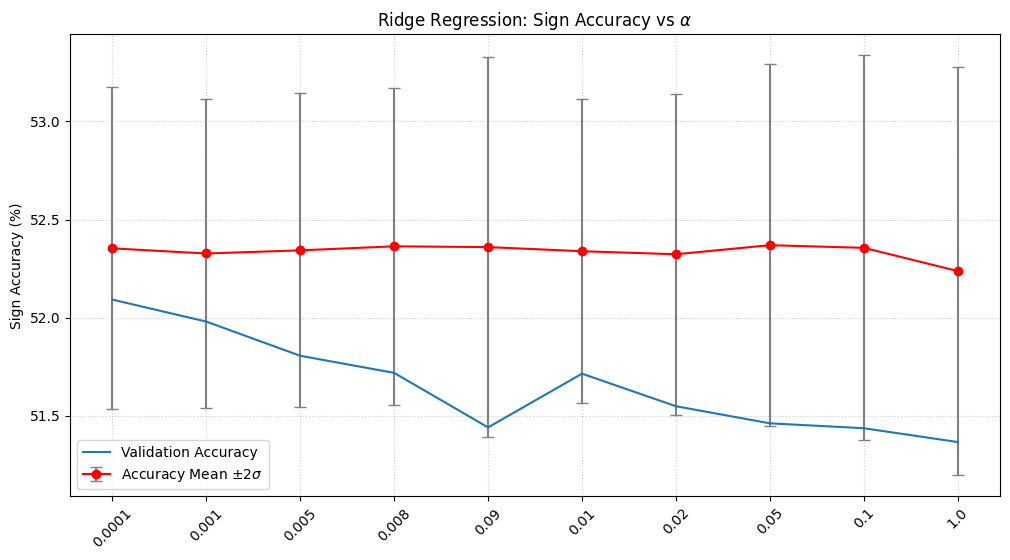

Optimal l2 penalization = 0.008
Ridge - CV Classification Accuracy: 52.36341510279894%, [51.959% ; 52.768%] (+- 0.404)
Ridge - Train Classification Accuracy: 52.45500544418113%
Ridge - Validation Set Classification : 51.718847190545304%


In [494]:
%time
# Upload Data
X_train, y_train, X_val, y_val, Test_data, sample_submission = upload_data_2()
X_train = pre_process_3(X_train)
X_val = pre_process_3(X_val)
Test_data = pre_process_3(Test_data)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
Test_data = Test_data.to_numpy()

# Cross Validation
alphas = np.array([1e-4, 0.001, 0.005, 0.008, 0.09, 0.01, 0.02, 0.05, 0.1, 1])
best_alpha = cross_validate_ridge(X_train, y_train, alphas, cv = 10,  plot = True, X_val = X_val, y_val = y_val, save = False)

model = Ridge(alpha=best_alpha, fit_intercept=False, solver='svd').fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(Test_data)

In [486]:
X_train, y_train, X_val, y_val, Test_data, sample_submission = upload_data_2()
X_train = pre_process_3(X_train)
X_val = pre_process_3(X_val)
Test_data = pre_process_3(Test_data)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
Test_data = Test_data.to_numpy()


features = RET_features + SIGNED_VOLUME_features + TURNOVER_features + allocations_AVERAGE_PERF_features + new_features + new_new_features
selected_features = regression_coefficients(X_train, y_train, features, alpha=best_alpha, return_selected=True)
print("Number of selected features", len(selected_features))

Number of selected features 42


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Linear Regression- Train Classification Accuracy: 52.26157689105233%
Linear Regression - Validation Set Classification : 51.72714078374455%


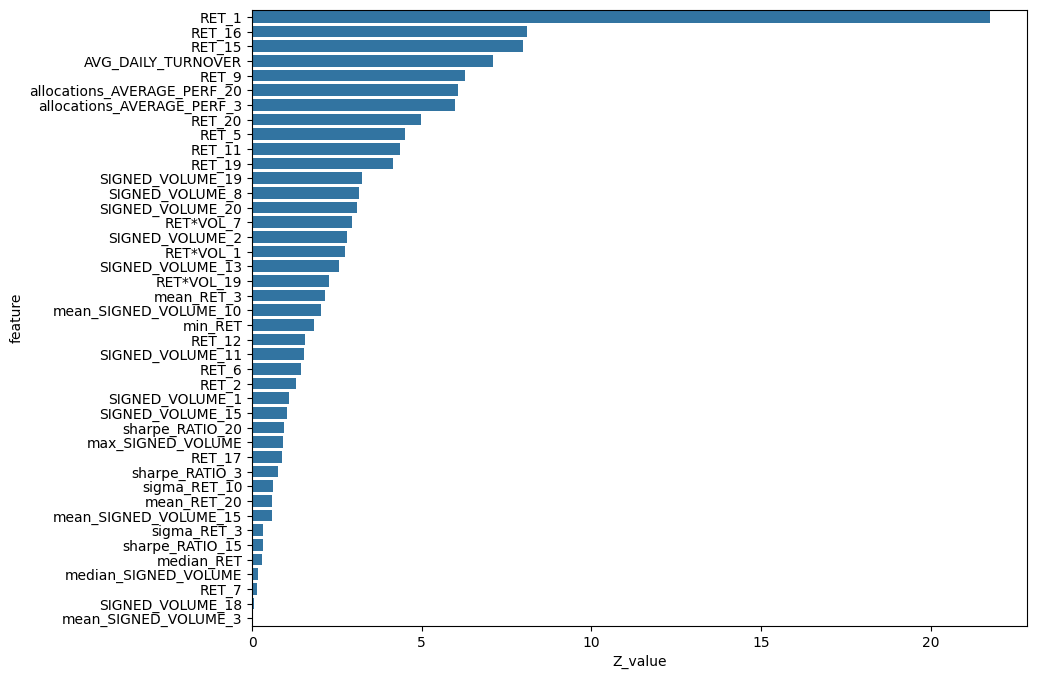

In [487]:
%time
# Upload Data
X_train, y_train, X_val, y_val, Test_data, sample_submission = upload_data_2()
X_train = pre_process_3(X_train)
X_val = pre_process_3(X_val)
Test_data = pre_process_3(Test_data)

X_train = X_train[selected_features]
X_val = X_val[selected_features]
Test_data = Test_data[selected_features]

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
Test_data = Test_data.to_numpy()


# Train Set Score
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(f'Linear Regression- Train Classification Accuracy: {np.mean(np.sign(model.predict(X_train)) == np.sign(y_train.flatten()))*100}%')
print(f'Linear Regression - Validation Set Classification : {np.mean(np.sign(model.predict(X_val)) == np.sign(y_val.flatten()))*100}%') # Valdiation Set Score
regression_coefficients(X_train, y_train, selected_features, alpha=0, barplot_zvalue=True)


# Linear Discrimant Analysis

In [488]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis().fit(X_train, (y_train > 0).astype(int))
print(f'LDA - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'LDA - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%') # Valdiation Set Score

LDA - Train Classification Accuracy: 52.389675270607825%
LDA - Validation Set Classification Accuracy : 51.710553597346056%


In [489]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train = np.concatenate([y_train_pred.reshape(-1, 1), X_train], axis = 1)
X_val = np.concatenate([y_val_pred.reshape(-1, 1), X_val], axis = 1)
Test_data = np.concatenate([y_test_pred.reshape(-1, 1), Test_data], axis = 1)

model = LinearDiscriminantAnalysis().fit(X_train, (y_train > 0).astype(int))
print(f'LDA - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'LDA - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%') # Valdiation Set Score

X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
Test_data = Test_data[:, 1:]

LDA - Train Classification Accuracy: 52.61704989431883%
LDA - Validation Set Classification Accuracy : 51.51150736056397%


In [490]:
# LDA + OneHotEncoding
encoder = OneHotEncoder().fit(X_train_alloc.to_numpy().reshape(-1, 1))
X_train = np.concatenate([X_train, encoder.transform(X_train_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
X_val = np.concatenate([X_val, encoder.transform(X_val_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
Test_data = np.concatenate([Test_data, encoder.transform(Test_data_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)

X_train = np.concatenate([y_train_pred.reshape(-1, 1), X_train], axis = 1)
X_val = np.concatenate([y_val_pred.reshape(-1, 1), X_val], axis = 1)
Test_data = np.concatenate([y_test_pred.reshape(-1, 1), Test_data], axis = 1)

model = LinearDiscriminantAnalysis().fit(X_train, (y_train > 0).astype(int))
print(f'LDA - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'LDA - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%')
save_pred(model.predict(Test_data), "Late004-LDA-alloc")

X_train = X_train[:, 1:len(selected_features)+1]
X_val = X_val[:, 1:1+len(selected_features)]
Test_data = Test_data[:, 1:1+len(selected_features)]

LDA - Train Classification Accuracy: 53.188368667136366%
LDA - Validation Set Classification Accuracy : 52.71822517105535%


# Logistic Regression

In [491]:
model = LogisticRegression().fit(X_train, (y_train > 0).astype(int))
print(f'Logistic regression - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'Logistic regression - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%')

Logistic regression - Train Classification Accuracy: 51.74213796195478%
Logistic regression - Validation Set Classification Accuracy : 51.776902342940076%


In [492]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train = np.concatenate([y_train_pred.reshape(-1, 1), X_train], axis = 1)
X_val = np.concatenate([y_val_pred.reshape(-1, 1), X_val], axis = 1)
Test_data = np.concatenate([y_test_pred.reshape(-1, 1), Test_data], axis = 1)

model = LogisticRegression().fit(X_train, (y_train > 0).astype(int))
print(f'Logistic regression - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'Logistic regression - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%')

X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
Test_data = Test_data[:, 1:]

Logistic regression - Train Classification Accuracy: 51.74213796195478%
Logistic regression - Validation Set Classification Accuracy : 51.772755546340456%


In [493]:
# Logistic Regression + OneHotEncoding
encoder = OneHotEncoder().fit(X_train_alloc.to_numpy().reshape(-1, 1))
X_train = np.concatenate([X_train, encoder.transform(X_train_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
X_val = np.concatenate([X_val, encoder.transform(X_val_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
Test_data = np.concatenate([Test_data, encoder.transform(Test_data_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)

X_train = np.concatenate([y_train_pred.reshape(-1, 1), X_train], axis = 1)
X_val = np.concatenate([y_val_pred.reshape(-1, 1), X_val], axis = 1)
Test_data = np.concatenate([y_test_pred.reshape(-1, 1), Test_data], axis = 1)

model = LogisticRegression().fit(X_train, (y_train > 0).astype(int))
print(f'Logistic regression - Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train > 0).astype(int)) * 100}%')
print(f'Logistic regression - Validation Set Classification Accuracy : {accuracy_score(model.predict(X_val), (y_val > 0).astype(int))*100}%')

X_train = X_train[:, 1:len(selected_features)+1]
X_val = X_val[:, 1:1+len(selected_features)]
Test_data = Test_data[:, 1:1+len(selected_features)]

Logistic regression - Train Classification Accuracy: 52.46397233075002%
Logistic regression - Validation Set Classification Accuracy : 51.98424217292141%


# XGBoost

In [446]:
%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7],
    'learning_rate': [0.0001, 0.1],
}

model = XGBClassifier(eval_metric='logloss', random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, (y_train > 0).astype(int))
model = grid_search.best_estimator_

print(f"Optimal Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy Score: {grid_search.best_score_ * 100:.2f}%")
print(f"Train Classification Accuracy: {accuracy_score(model.predict(X_train), (y_train>0).astype(int)) * 100}%")
print(f"Validation Set Classification Accuracy: {accuracy_score(model.predict(X_val), (y_val>0).astype(int)) * 100}%")


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best CV Accuracy Score: 58.48%
Train Classification Accuracy: 50.37762237762238%
Validation Set Classification Accuracy: 96.52498444951276%


In [456]:
encoder = OneHotEncoder().fit(X_train_alloc.to_numpy().reshape(-1, 1))
X_train = np.concatenate([X_train, encoder.transform(X_train_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
X_val = np.concatenate([X_val, encoder.transform(X_val_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)
Test_data = np.concatenate([Test_data, encoder.transform(Test_data_alloc.to_numpy().reshape(-1, 1)).toarray()], axis=1)

X_train = np.concatenate([y_train_pred.reshape(-1, 1), X_train], axis = 1)
X_val = np.concatenate([y_val_pred.reshape(-1, 1), X_val], axis = 1)
Test_data = np.concatenate([y_test_pred.reshape(-1, 1), Test_data], axis = 1)

import itertools
param_grid = {
    'n_estimators': [50, 60, 80, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01],
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_score = -1.0
best_params = None


for i, params in enumerate(param_combinations):

    model = XGBClassifier(eval_metric='logloss', random_state=42, **params)

    model.fit(X_train, (y_train > 0).astype(int))
    val_score = accuracy_score((y_val >0).astype(int), model.predict(X_val))

    if val_score > best_val_score:
        best_val_score = val_score
        best_params = params


print(f"Optimal Parameters (based on X_val): {best_params}")
print(f"Best Validation Accuracy: {best_val_score * 100:.2f}%")

# Train the final model using the best parameters found
model = XGBClassifier(eval_metric='logloss',random_state=42, **best_params).fit(X_train, (y_train > 0).astype(int))

X_train = X_train[:, 1:len(selected_features)+1]
X_val = X_val[:, 1:1+len(selected_features)]
Test_data = Test_data[:, 1:1+len(selected_features)]

Tested combination 1/12: Score = 0.5040
Tested combination 2/12: Score = 0.5094
Tested combination 3/12: Score = 0.5021
Tested combination 4/12: Score = 0.5044
Tested combination 5/12: Score = 0.5107
Tested combination 6/12: Score = 0.5031
Tested combination 7/12: Score = 0.5047
Tested combination 8/12: Score = 0.5096
Tested combination 9/12: Score = 0.5032
Tested combination 10/12: Score = 0.5053
Tested combination 11/12: Score = 0.5074
Tested combination 12/12: Score = 0.5045

--- Validation-Only Tuning Results ---
Optimal Parameters (based on X_val): {'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.01}
Best Validation Accuracy: 51.07%
